In [1]:
from scipy.stats import gamma, norm, poisson
from scipy.special import logsumexp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

,Year,Count
0,1851,4
1,1852,5
2,1853,4
3,1854,1
4,1855,0


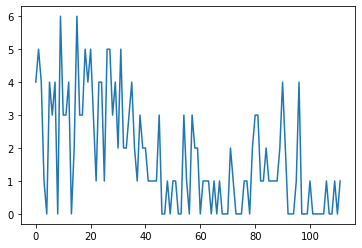

In [2]:
#Import dataset
coal_dat = pd.read_csv("coaldisasters-ds6040.csv")
coal_dat['Count'].plot()
coal_dat.head()

## Question 1

(50 points) With the above information, complete the Gibbs sampler in the accompanying notebook. You should only need to complete the update steps for the µ and λ (called lambdap in the notebook) parameters. Run the Gibbs sampler, plot the posterior densities and calculate the EAP estimates with 95% (equal tailed) credible intervals for µ and λ. Provide the top 5 most probable values of k. Then do the the following:

In [3]:
def log_like(x_data, mu, lamb, k):
    n = len(x_data)
    first_chunks = poisson.logpmf(x_data[0:k], mu) 
    second_chunks = poisson.logpmf(x_data[(k):n], lamb)
    return np.sum(first_chunks) + np.sum(second_chunks)

# example call
log_like(np.random.choice(4, size=3), 1, 2, 3)

-3.6931471805599454

In [4]:
def samp_k(x_data, mu, lamb):
    n = len(x_data)
    possible_ks = np.arange(n)
    log_unnorm_weights = [log_like(x_data, mu, lamb, k) for k in possible_ks] # to do!
    log_denominator = logsumexp(log_unnorm_weights)
    log_norm_weights = log_unnorm_weights - log_denominator
    return np.random.choice(n, size=1, p=np.exp(log_norm_weights))[0]

samp_k(coal_dat['Count'], 2, 2)

103

In [5]:
class CoalDisasterModel():
    """Gibbs Sampler"""
    def __init__(self, data, a_mu, b_mu, a_lambda, b_lambda, 
                 start_mu = 5, start_lambda = .1, start_k = 64, iter_num = 1000, burnin = 500):
        
        #Read in data and priors, and make them contained class variables
        self.data = data
        self.a_mu = a_mu
        self.b_mu = b_mu
        self.a_lambda = a_lambda
        self.b_lambda = b_lambda
        self.iter_num = iter_num
        self.burnin = burnin
        
        #Initalize sampling containers
        self.mu = np.zeros(iter_num+burnin+1)
        self.lambdap = np.zeros(iter_num+burnin+1)
        self.k = np.zeros(iter_num+burnin+1)
        
        #Put in starting values
        self.mu[0] = start_mu
        self.lambdap[0] = start_lambda
        self.k[0] = start_k     
        
        for i in np.arange(iter_num+burnin):
            if i % 100 == 0:
                print("Iteration " + str(i))
            
            
            #This is where you modify the sampler
            self.mu[i+1] = gamma.rvs(a_mu + self.data[0:int(self.k[i])].sum(),scale = 1 / (self.k[i] + b_mu))
            self.lambdap[i+1] = gamma.rvs(a_lambda + self.data[int(self.k[i]):len(self.data)].sum(), scale = 1 / (len(self.data) - self.k[i] + b_lambda))
            self.k[i+1] = samp_k(self.data, self.mu[i+1], self.lambdap[i+1])
            
    def plot_posteriors(self):
        f, axs = plt.subplots(3,2, figsize = (15, 7))
        f.tight_layout(pad = 3)
        sns.kdeplot(self.mu[self.burnin:],ax =axs[0,0])
        axs[0,0].set_xlabel(r'Posterior $\mu$')
        axs[0,0].set_ylabel('Probability Density')
        sns.kdeplot(self.lambdap[self.burnin:], ax =axs[1,0])
        axs[1,0].set_xlabel(r'Posterior $\lambda$')
        axs[1,0].set_ylabel('Probability Density')
        axs[2,0].hist(self.k[self.burnin:], bins = 112)
        axs[2,0].set_xlabel(r'Posterior k')
        axs[2,0].set_ylabel('Frequency')
        axs[0,1].plot(np.arange(self.iter_num+self.burnin+1),self.mu, '-')
        axs[0,1].set_xlabel('')
        axs[0,1].set_ylabel(r'Posterior $\mu$')
        axs[1,1].plot(np.arange(self.iter_num+self.burnin+1),self.lambdap,'-')
        axs[1,1].set_xlabel('')
        axs[1,1].set_ylabel(r'Posterior $\lambda$')
        axs[2,1].plot(np.arange(self.iter_num+self.burnin+1),self.k,'-')
        axs[2,1].set_xlabel('Iteration')
        axs[2,1].set_ylabel('Posterior k')
    
    def get_rate_estimates(self):
        to_return =pd.DataFrame(columns = ['Posterior EAP', 'Posterior Cred Interval Lower', 'Posterior Cred Interval Upper'])
        to_return.loc[r'mu', 'Posterior EAP'] = self.mu[self.burnin:].mean()
        to_return.loc[r'lambda', 'Posterior EAP'] = self.lambdap[self.burnin:].mean()
        to_return.loc[r'mu', 'Posterior Cred Interval Lower'] = np.quantile(self.mu[self.burnin:],.025)
        to_return.loc[r'lambda', 'Posterior Cred Interval Lower'] = np.quantile(self.lambdap[self.burnin:],.025)
        to_return.loc[r'mu', 'Posterior Cred Interval Upper'] = np.quantile(self.mu[self.burnin:],.975)
        to_return.loc[r'lambda', 'Posterior Cred Interval Upper'] = np.quantile(self.lambdap[self.burnin:],.975)
        return to_return
    
    def get_k_probs(self):
        freq = np.bincount(abs(self.k.astype('int'))[self.burnin:])
        ii = np.nonzero(freq)[0]
        freq = np.vstack((ii,freq[ii])).T
        freq = freq.astype("float16")
        freq[:,1] = freq[:,1]/(freq[:,1].sum())
        freq = pd.DataFrame(freq, columns=['k', 'Probability of k'])
        
        return freq

In [6]:
test = CoalDisasterModel(coal_dat['Count'], 1,1,1,1)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400


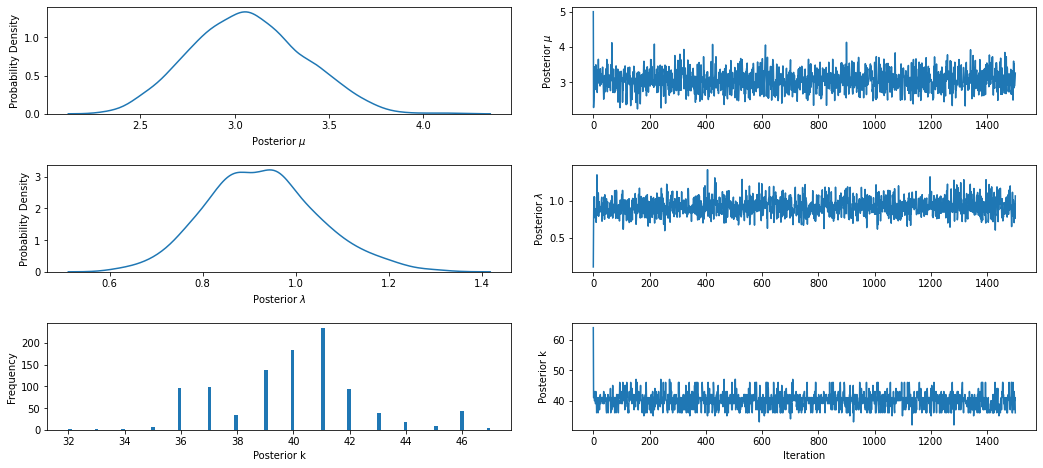

In [7]:
test.plot_posteriors()

In [8]:
test.get_rate_estimates()

,Posterior EAP,Posterior Cred Interval Lower,Posterior Cred Interval Upper
mu,3.068813,2.518185,3.648885
lambda,0.927988,0.708361,1.18548


In [9]:
temp = pd.DataFrame(pd.Series(test.k).value_counts()).reset_index()
temp["year"]= temp["index"] + 1851
temp[0:5]

,index,0,year
0,41.0,358,1892.0
1,40.0,274,1891.0
2,39.0,204,1890.0
3,42.0,149,1893.0
4,37.0,145,1888.0


#### 1-A
Describe your findings. What do these EAP and credible intervals imply? And what was the most likely year of the changepoint?

With the assumption that we know there is a changepoint for the counts of coal mining disasters, we can compare the posterior EAP of mu and lambda to the original count plot. In the count plot we see that until k=40, the mean of disasters were higher than that of after k=40. Also, from our EAP estimates and the credible intervals we can observe that there is no overlap between the two intervals. This may allude to there being a chagne in behavior of the coal mining distator, which means two seperate distributions exists. We can also give insight to the most probable k, which is shown above as 41, 40, 39, 42, or 37. Looking in retrospect, these values were very close to what we originally saw from the counts plot as well.

#### 1-B
Why is an EAP or credible interval not necessarily the most appropriate thing to report for the year of the changepoint?

Although, the EAP in this case was useful for our interpretation the nature of bayesian is very flexible. This analysis could have been done similaly with MAP, which may have brough some different conclusions. Along with this, changing prior information could drastically change the EAP and credible intervals as well. Therefore, EAP can come in handy when showcasing a changepoint, but can be very vulnerable in the sense that it can be heavily manipulated. The most apprportiate thing to report in my opinon will be the postrior for K with the EAP being additional information to deliever a conclusion. 

## Question 2

#### Q2-1
(40 points) Load the data from whitewine-training-ds6040.csv and create a new 0/1 quality variable, where the new quality of the wine is 0 if the wine received a C or F, and 1 if the wine received an A.

In [10]:
wine_data = pd.read_csv("whitewine-training-ds6040.csv")
wine_data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C


In [11]:
replace_map = {'C':0, 
               'F':0, 
               'A':1}
wine_data["wine_class"] = wine_data["wine_quality"].map(replace_map)
wine_data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,wine_quality,wine_class
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C,0
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C,0
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C,0
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0


#### Q2-2
Using the notebook BayesLogisticRegression.ipynb as an implementation guide, fit two logistic regression models chosen as follows (Note: you won’t be penalized if you, for example, did something in the HW2 incorrectly and are presenting models I don’t expect): 

- Choose the set of 3 variables that in HW2 gave you the best classification rate overall within the training data. 
- Choose the set of 3 variables that gave you the best classification rates of A grade wines in the training dataset (you will have to look back into HW2, and make some slight modifications to your code to obtain this information. Hint, you need to use the cross-tab information).

Once you have fit your two models, plot both traceplots and forestplots using code from the BayesLogisticRegression notebook. Discuss your findings. Note that I am not asking you to calculate miss-classification rates, rather to examine your parameter distributions and explain what those estimates mean, and how they compare to one another. Don’t forget to interpret the intercept as well.

##### Part1
The 3 variables that gave me a great model in terms of traiing data were the following.
- volatile.acidity
- density
- alcohol

For the purpose of this question, we will rename the column volatile.acidity as volatile_acidity as well as all other columns that follow the same naming conventions

In [12]:
wine_data.columns = [x.replace('.','_') if '.' in x else x for x in wine_data.columns]
wine_data.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,wine_quality,wine_class
0,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0
1,-0.640290,0.206999,0.056475,-0.946679,0.142355,-1.246502,-0.149673,-0.008274,0.711107,0.011581,-0.831034,C,0
2,1.476825,0.010158,0.558982,0.092590,0.187465,-0.319775,-0.973515,0.353398,0.452130,-0.423446,-0.347387,C,0
3,-0.757907,0.403840,-1.451043,0.112199,-0.038083,-0.319775,-0.055520,0.287640,-0.065824,-0.162430,-0.750426,C,0
4,0.183032,-0.088263,0.223977,2.798612,-0.038083,0.549032,0.744783,2.293274,-1.231221,-0.336441,-1.395289,C,0


In [13]:
import pymc3 as pm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alcohol, density, volatile_acidity, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_54766/2983004727.py:9: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.plots.forestplot(trace1, figsize = (12,5))
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` wit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.906,0.149,-4.189,-3.640,0.003,0.002,2388.0,2399.0,1.0
volatile_acidity,-0.357,0.129,-0.590,-0.114,0.003,0.002,2465.0,1992.0,1.0
density,0.226,0.158,-0.094,0.498,0.003,0.003,2261.0,2266.0,1.0
alcohol,1.139,0.167,0.831,1.447,0.004,0.003,1975.0,1776.0,1.0


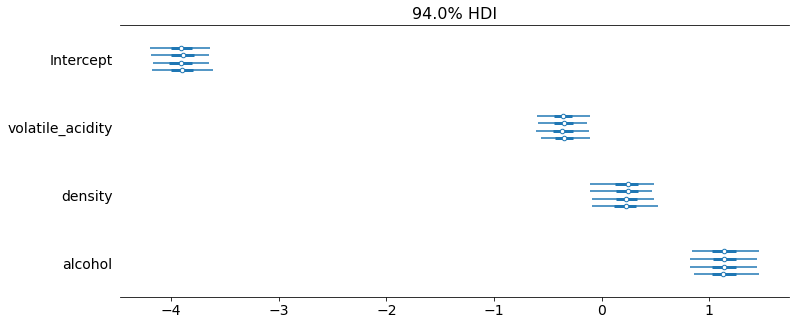

In [14]:
with pm.Model() as model1:
    pm.glm.GLM.from_formula(formula = 'wine_class ~ volatile_acidity + density + alcohol', 
                            data = wine_data, 
                            family = pm.glm.families.Binomial())

    trace1 = pm.sample(1000)

#You can obtain forest plots with:
pm.plots.forestplot(trace1, figsize = (12,5))

#You can get a table of summary statistics out using:
pm.summary(trace1)

Discuss Findings

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'volatile_acidity'}>,
        <AxesSubplot:title={'center':'volatile_acidity'}>],
       [<AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'alcohol'}>]], dtype=object)

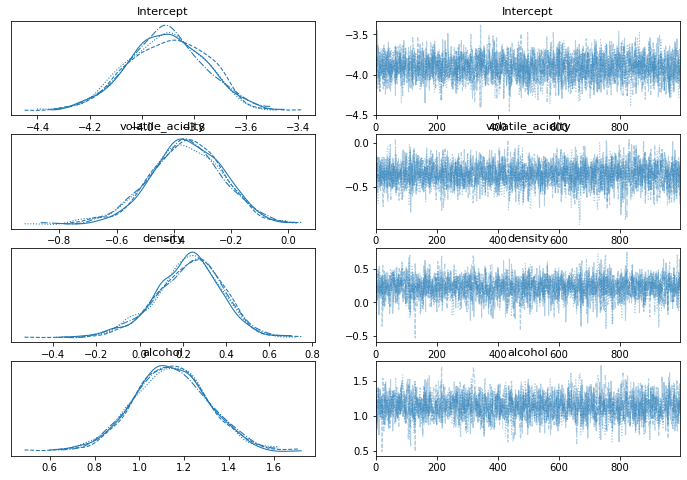

In [15]:
## TracePlot
az.plot_trace(trace1)

##### Part2
Choose the set of 3 variables that gave you the best classification rates of A grade wines in the training dataset (you will have to look back into HW2, and make some slight modifications to your code to obtain this information. Hint, you need to use the cross-tab information).

First I will rerun the LDA model for the training data from HW 2 to calculate the best classification for the class A using non informative priors

In [16]:
from scipy.stats import multivariate_normal
class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

In [17]:
import itertools
hw2_data_rerun = pd.read_csv("whitewine-training-ds6040.csv")
error_rates_combinations = []
for i in itertools.combinations(hw2_data_rerun.columns[:-1], 3):
    combination = list(i) + ["wine_quality"]
    flat_priors_lda = LDA(hw2_data_rerun[combination], 'wine_quality')
    error_for_class_A = flat_priors_lda.misclass_xtabs()["A"][0] / sum(flat_priors_lda.misclass_xtabs()["A"])
    error_rates_combinations.append([",".join(combination[:-1]), error_for_class_A])
df_error_rates_combinations = pd.DataFrame(error_rates_combinations)
df_error_rates_combinations.columns = ["combinations",\
                                       "class_A_correct"]

In [18]:
df_error_rates_combinations.sort_values("class_A_correct", ascending=False)

,combinations,class_A_correct
140,"chlorides,density,sulphates",0.72
79,"volatile.acidity,pH,alcohol",0.72
159,"total.sulfur.dioxide,pH,alcohol",0.72
135,"chlorides,total.sulfur.dioxide,density",0.72
107,"citric.acid,pH,alcohol",0.72
...,...,...
97,"citric.acid,free.sulfur.dioxide,sulphates",0.30
47,"volatile.acidity,citric.acid,free.sulfur.dioxide",0.30
7,"fixed.acidity,volatile.acidity,sulphates",0.29
69,"volatile.acidity,free.sulfur.dioxide,sulphates",0.28


The 3 variables that gave me a great model in terms of traiing data for the class A were the following.
- chlorides
- density
- sulphates

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/
/usr/local/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sulphates, density, chlorides, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/var/folders/pn/dgy7ckd90nl7mlj6g6rc_1kw0000gn/T/ipykernel_54766/345171114.py:10: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.plots.forestplot(trace2, figsize = (12,5))
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` wit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.745,0.133,-3.997,-3.504,0.002,0.002,3038.0,2775.0,1.0
chlorides,-0.518,0.222,-0.918,-0.087,0.004,0.003,3197.0,3090.0,1.0
density,-0.623,0.135,-0.897,-0.391,0.002,0.002,3147.0,3009.0,1.0
sulphates,0.038,0.100,-0.142,0.230,0.002,0.002,3095.0,2557.0,1.0


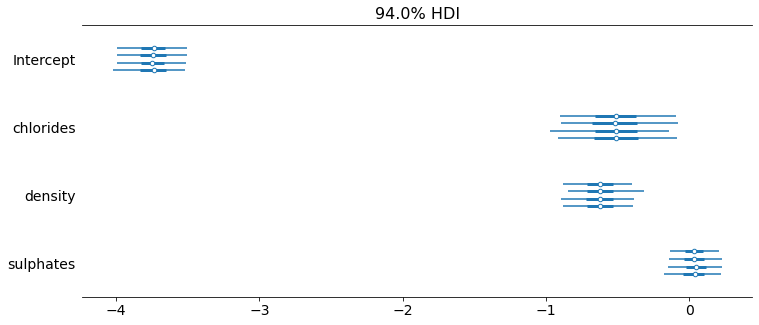

In [19]:
with pm.Model() as model2:
    pm.glm.GLM.from_formula(formula = 'wine_class ~ chlorides + density + sulphates', 
                            data = wine_data, 
                            family = pm.glm.families.Binomial())

    trace2 = pm.sample(1000)


#You can obtain forest plots with:
pm.plots.forestplot(trace2, figsize = (12,5))

#You can get a table of summary statistics out using:
pm.summary(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'chlorides'}>],
       [<AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'density'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'sulphates'}>]], dtype=object)

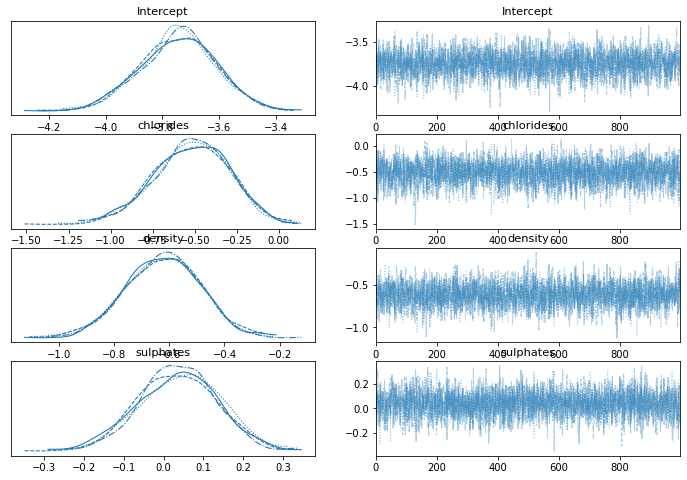

In [20]:
## TracePlot
az.plot_trace(trace2)

Discuss your findings. Note that I am not asking you to calculate miss-classification rates, rather to examine your parameter distributions and explain what those estimates mean, and how they compare to one another. Don’t forget to interpret the intercept as well.

Lets first look at the summaries for the two models first.

In [21]:
pm.summary(trace1)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.906,0.149,-4.189,-3.640,0.003,0.002,2388.0,2399.0,1.0
volatile_acidity,-0.357,0.129,-0.590,-0.114,0.003,0.002,2465.0,1992.0,1.0
density,0.226,0.158,-0.094,0.498,0.003,0.003,2261.0,2266.0,1.0
alcohol,1.139,0.167,0.831,1.447,0.004,0.003,1975.0,1776.0,1.0


In [22]:
pm.summary(trace2)

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-3.745,0.133,-3.997,-3.504,0.002,0.002,3038.0,2775.0,1.0
chlorides,-0.518,0.222,-0.918,-0.087,0.004,0.003,3197.0,3090.0,1.0
density,-0.623,0.135,-0.897,-0.391,0.002,0.002,3147.0,3009.0,1.0
sulphates,0.038,0.100,-0.142,0.230,0.002,0.002,3095.0,2557.0,1.0


From the summaries we can see that for both models the intercept was negative. This means that for the first model if volatile_acidity, density, and alcohol were set to 0, the prediction will lean towards 0, which in context of the problem is for the wine types of C and F. This makes sense because a wine that has 0 density and 0 alcohol and 0 volatile_acidity will probably not be the best wine. The same ideology translates into the second model. A wine with no chlorides and no density and no sulphates will not be classified as good wine. 

We can further inspect the first model. WE noticed that the volatile_acidity was the only predictor that had a negative slope. This means that as the volatile_acidity for a wine goes up the more likely it will be classified as a bad wine. For density the mean was positive, but the the HDI contained 0. On average the more density the wine had the more probable the wine will be classified as A, but since the interval contained 0, more investigation must be done to solidify this statement. The last parameter alcohol, had a positive mean as well and the HDI did not contain 0. Therefore, it can be said that the more alcohol the wine had the better it would be classified as wine type A. Maybe this alludes to slamming more alcohol into a wine will always make it better? 

The second model, which was aimed towards the best predictors to best predict the best wines rather than the overal wine classifications showed three different predictors of chlorides, density, and sulphates. The density predictor was the only predictor that overlapped with the other model. In this case, density had a negative slope and the HDI did not contain 0. For interpretation, the more dense a wine is the more likely it would be classified as a non good wine. Tied to the real world this makes sense because if a wine is too dense, a customer may not like how it is not "smooth". Chlorides showed a similar behavior to density and the interpretation is similar; the more chlorides there are in a wine type the more likely it will be classified as a bad (C, and F) wine. In the second model the only predictor with a positive slope was sulphates. However, the HDI interval contained 0, which may mean that sulphates may not have a big playing factor in the prediction of wine quality. In the real world, we know that sulphates are good for better tasting wine and better shell life. However, from that knowledge and the model we can not definitely say that more sulphates will be better wine. 